In [ ]:
#| include: false
from nbdev.showdoc import *

Neural Network Pruning usually follows one of the next 3 schedules:

![](../../imgs/schedules.png "Schedules")

In fasterai, all those 3 schedules can be applied from the **same** callback. We'll cover each below

In the SparsifyCallback, there are several parameters to 'shape' our pruning schedule:
* `start_sparsity`: the initial sparsity of our model, generally kept at 0 as after initialization, our weights are generally non-zero.
* `end_sparsity`: the target sparsity at the end of the training 
* `start_epoch`: we can decide to start pruning right from the beginning or let it train a bit before removing weights.
* `sched_func`: this is where the general shape of the schedule is specified as it specifies how the sparsity evolves along the training. You can either use a schedule [available](https://docs.fast.ai/callback.schedule.html#Annealing) in fastai our even coming with your own !

---

In [ ]:
#| include: false
from fastai.vision.all import *
from fastai.callback.all import *

from fasterai.sparse.all import *

import torch
import torch.nn as nn
import torch.nn.functional as F

import seaborn as sns

sns.set(context='poster', style='white',
        font='sans-serif', font_scale=1, color_codes=True, rc=None)

In [ ]:
path = untar_data(URLs.PETS)

files = get_image_files(path/"images")

def label_func(f): return f[0].isupper()

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

dls = ImageDataLoaders.from_name_func(path, files, label_func, item_tfms=Resize(64), device=device)

We will first train a network without any pruning, which will serve as a baseline.

In [ ]:
learn = vision_learner(dls, resnet18, metrics=accuracy)
learn.unfreeze()

learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,accuracy,time
0,0.730013,0.506678,0.855210,00:02
1,0.447686,0.506973,0.859269,00:02
2,0.301127,0.411056,0.852503,00:02
3,0.191690,1.049522,0.734777,00:02
4,0.172791,0.237312,0.898512,00:02
5,0.122015,0.413614,0.876861,00:02
6,0.101531,0.221184,0.922192,00:02
7,0.065968,0.188157,0.929635,00:02
8,0.037767,0.185539,0.932341,00:02
9,0.020217,0.186808,0.930988,00:02


## One-Shot Pruning

The simplest way to perform pruning is called One-Shot Pruning. It consists of the following three steps:

1. You first need to train a network
2. You then need to remove some weights (depending on your criteria, needs,...)
3. You fine-tune the remaining weights to recover from the loss of parameters.

With fasterai, this is really easy to do. Let's illustrate it by an example:

In [ ]:
learn = vision_learner(dls, resnet18, metrics=accuracy)
learn.unfreeze()

In this case, your network needs to be trained before pruning. This training can be done independently from the pruning callback, or simulated by the `start_epoch` that will delay the pruning process.

You thus only need to create the Callback with the `one_shot` schedule and set the `start_epoch` argument, i.e. how many epochs you want to train your network before pruning it.

In [ ]:
sp_cb=SparsifyCallback(sparsity=90, granularity='weight', context='local', criteria=large_final, schedule=one_shot)

Let's start pruningn after 3 epochs and train our model for 6 epochs to have the same total amount of training as before

In [ ]:
learn.fit(10, cbs=sp_cb)

Pruning of weight until a sparsity of [90]%
Saving Weights at epoch 0


epoch,train_loss,valid_loss,accuracy,time
0,0.506444,0.326561,0.865359,00:02
1,0.328817,0.297439,0.876184,00:02
2,0.233747,0.295782,0.876861,00:02
3,0.196205,0.245007,0.898512,00:02
4,0.183628,0.371088,0.855886,00:02
5,0.220700,0.236046,0.903924,00:02
6,0.158499,0.218260,0.914750,00:02
7,0.108752,0.276276,0.897158,00:02
8,0.091520,0.266384,0.908660,00:03
9,0.075346,0.260405,0.912720,00:03


Sparsity at the end of epoch 0: [0.0]%
Sparsity at the end of epoch 1: [0.0]%
Sparsity at the end of epoch 2: [0.0]%
Sparsity at the end of epoch 3: [0.0]%
Sparsity at the end of epoch 4: [90.0]%
Sparsity at the end of epoch 5: [90.0]%
Sparsity at the end of epoch 6: [90.0]%
Sparsity at the end of epoch 7: [90.0]%
Sparsity at the end of epoch 8: [90.0]%
Sparsity at the end of epoch 9: [90.0]%
Final Sparsity: [90.0]%

Sparsity Report:
--------------------------------------------------------------------------------
Layer                Type            Params     Zeros      Sparsity  
--------------------------------------------------------------------------------
Layer 0              Conv2d          9,408      8,467         90.00%
Layer 1              Conv2d          36,864     33,177        90.00%
Layer 2              Conv2d          36,864     33,177        90.00%
Layer 3              Conv2d          36,864     33,177        90.00%
Layer 4              Conv2d          36,864     33,177

---

## Iterative Pruning

Researchers have come up with a better way to do pruning than pruning all the weigths in once (as in One-Shot Pruning). The idea is to perform several iterations of pruning and fine-tuning and is thus called Iterative Pruning.

1. You first need to train a network
2. You then need to remove a part of the weights weights (depending on your criteria, needs,...)
3. You fine-tune the remaining weights to recover from the loss of parameters.
4. Back to step 2.

In [ ]:
learn = vision_learner(dls, resnet18, metrics=accuracy)
learn.unfreeze()

In this case, your network needs to be trained before pruning.

You only need to create the Callback with the `iterative` schedule and set the `start_epoch` argument, i.e. how many epochs you want to train your network before pruning it.

The `iterative` schedules has a `n_steps`parameter, i.e. how many iterations of pruning/fine-tuning you want to perform. To modify its value, we can use the `partial` function like this:

```
iterative = partial(iterative, n_steps=5)
```

In [ ]:
sp_cb=SparsifyCallback(sparsity=90, granularity='weight', context='local', criteria=large_final, schedule=iterative)

Let's start pruningn after 3 epochs and train our model for 6 epochs to have the same total amount of training as before

In [ ]:
learn.fit(10, cbs=sp_cb)

Pruning of weight until a sparsity of [90]%
Saving Weights at epoch 0


epoch,train_loss,valid_loss,accuracy,time
0,0.587861,0.445379,0.807848,00:03
1,0.378933,0.352540,0.843031,00:03
2,0.242702,0.266449,0.887686,00:03
3,0.179028,0.272386,0.902571,00:03
4,0.162178,0.279316,0.893099,00:03
5,0.111868,0.228351,0.915426,00:03
6,0.079438,0.263948,0.902571,00:03
7,0.199800,0.270281,0.895805,00:03
8,0.154339,0.258268,0.899188,00:02
9,0.111918,0.237054,0.895129,00:02


Sparsity at the end of epoch 0: [0.0]%
Sparsity at the end of epoch 1: [0.0]%
Sparsity at the end of epoch 2: [30.0]%
Sparsity at the end of epoch 3: [30.0]%
Sparsity at the end of epoch 4: [60.0]%
Sparsity at the end of epoch 5: [60.0]%
Sparsity at the end of epoch 6: [60.0]%
Sparsity at the end of epoch 7: [90.0]%
Sparsity at the end of epoch 8: [90.0]%
Sparsity at the end of epoch 9: [90.0]%
Final Sparsity: [90.0]%

Sparsity Report:
--------------------------------------------------------------------------------
Layer                Type            Params     Zeros      Sparsity  
--------------------------------------------------------------------------------
Layer 0              Conv2d          9,408      8,467         90.00%
Layer 1              Conv2d          36,864     33,177        90.00%
Layer 2              Conv2d          36,864     33,177        90.00%
Layer 3              Conv2d          36,864     33,177        90.00%
Layer 4              Conv2d          36,864     33,1

---

## Gradual Pruning

Here is for example how to implement the [Automated Gradual Pruning](https://arxiv.org/pdf/1710.01878.pdf) schedule.

In [ ]:
learn = vision_learner(dls, resnet18, metrics=accuracy)
learn.unfreeze()

In [ ]:
sp_cb=SparsifyCallback(sparsity=90, granularity='weight', context='local', criteria=large_final, schedule=agp)

Let's start pruning after 3 epochs and train our model for 6 epochs to have the same total amount of training as before

In [ ]:
learn.fit(10, cbs=sp_cb)

Pruning of weight until a sparsity of [90]%
Saving Weights at epoch 0


epoch,train_loss,valid_loss,accuracy,time
0,0.549385,0.390797,0.838295,00:02
1,0.341528,0.296461,0.873478,00:02
2,0.257936,0.237583,0.895805,00:02
3,0.183226,0.239204,0.896482,00:03
4,0.178959,0.478512,0.843708,00:04
5,0.174062,0.327999,0.855886,00:04
6,0.158133,0.255580,0.887686,00:04
7,0.145823,0.275189,0.893099,00:02
8,0.115836,0.210172,0.921516,00:02
9,0.081369,0.236233,0.926252,00:02


Sparsity at the end of epoch 0: [0.0]%
Sparsity at the end of epoch 1: [0.0]%
Sparsity at the end of epoch 2: [29.71]%
Sparsity at the end of epoch 3: [52.03]%
Sparsity at the end of epoch 4: [68.03]%
Sparsity at the end of epoch 5: [78.75]%
Sparsity at the end of epoch 6: [85.25]%
Sparsity at the end of epoch 7: [88.59]%
Sparsity at the end of epoch 8: [89.82]%
Sparsity at the end of epoch 9: [90.0]%
Final Sparsity: [90.0]%

Sparsity Report:
--------------------------------------------------------------------------------
Layer                Type            Params     Zeros      Sparsity  
--------------------------------------------------------------------------------
Layer 0              Conv2d          9,408      8,467         90.00%
Layer 1              Conv2d          36,864     33,177        90.00%
Layer 2              Conv2d          36,864     33,177        90.00%
Layer 3              Conv2d          36,864     33,177        90.00%
Layer 4              Conv2d          36,864  

Even though they are often considered as different pruning methods, those 3 schedules can be captured by the same Callback. Here is how the sparsity in the network evolves for those methods;

Let's take an example here. Let's say that we want to train our network for 3 epochs without pruning and then 7 epochs with pruning.

In [ ]:
#| include: false
train = np.zeros(300)
prune = np.linspace(0,1, 700) 

Then this is what our different pruning schedules will look like:

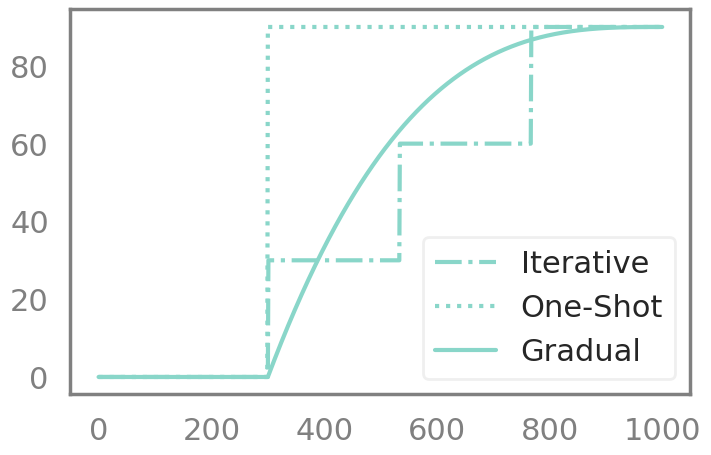

In [ ]:
#| echo: false
fig, ax = plt.subplots(1, 1, figsize=(8,5), dpi=100)
fig.patch.set_alpha(0.)
ax.patch.set_alpha(0.)
plt.plot(np.concatenate([train, sched_iterative(0,90, prune)]), label='Iterative', linestyle='-.', c='#89d6c9')
plt.plot(np.concatenate([train, [sched_oneshot(0,90, p) for p in prune]]), label='One-Shot', linestyle=':', c='#89d6c9')
plt.plot(np.concatenate([train, sched_agp(0,90, prune)]), label='Gradual', c='#89d6c9')
ax.spines['bottom'].set_color('#808080')
ax.spines['top'].set_color('#808080') 
ax.spines['right'].set_color('#808080')
ax.spines['left'].set_color('#808080')
ax.tick_params(axis='x', colors='#808080')
ax.tick_params(axis='y', colors='#808080')
ax.yaxis.label.set_color('#808080')
ax.xaxis.label.set_color('#808080')
plt.legend(framealpha=0.3);

**You can also come up with your own pruning schedule !**